In [8]:
import os, sys
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
VERSION = '08'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive')
    root_path = 'gdrive/My Drive/Colab Notebooks/deep_mouse/'
    print('Working on google colab')
except:
    root_path = '../'
    print('Working locally')

directory= f'{root_path}models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)    
    
sys.path.append(f'{root_path}/rsc/{VERSION}') # Adds pyLi directory to python modules path.
from load_data import load_data
from pre_process_data import pre_process_data
from create_model import create_model
from helper import play_bell, LossHistory, add_grid_and_save
from train_model import train_model
from run_training import run_training
from parameter_space import Parameter_space


Working locally


## Hyperparameters setting

In [18]:
def create_grid(params={}):
    
    grid_file_path = '{}/model_data/grid_{}.pkl'.format(root_path, VERSION)
    
    if os.path.isfile(grid_file_path):
        grid_df = pd.read_pickle(grid_file_path)
        test_index = grid_df['test_index'].max() + 1
    else:
        test_index = 0

    current_grid = {
        'version'                : ['str'     , VERSION],
        'params'                 : ['O'       , params],
        'test_index'             : [np.int    , test_index],
        'root_path'              : ['str'     , root_path],
        
        # Load and preprocess
        'batch_size_data'        : [np.int    , 200],
        'x_std'                  : [np.float  , 3.398],
        'y_std'                  : [np.float  , 2.926],
        'sigma_cut'              : [np.float  , 0.1],
        'training_size'          : [np.int    , 200],
        
        # Metrics
        'dropout'                 : [np.float  , 0.],
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        
        # Random seeds
        'seed_skf'               : [np.int    , 0],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        
        # Model properties
        'input_shape'            : ['O'       , None],
        'LSTM_size'              : [np.int    , 200],
        'dropout'                : [np.float  , 0],
        
        # Training parameters
        'learning_rate'          : [np.float  , 1.3e-4],
        'batch_size'             : [np.int    , 32],
        'epochs'                 : [np.int    , 200],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        
        # Outputs
        'best_model_paths'       : ['O'       , []],
        'best_model_accuracies'  : ['O'       , []],
        'fit_outs'               : ['O'       , []]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

### Run training

In [19]:
grid = create_grid()

X_train, X_test, y_train, y_test = load_data(grid)
X_train, y_train = pre_process_data(X_train, y_train, grid)
X_test, y_test = pre_process_data(X_test, y_test, grid)

In [20]:
def test_params(training_points):
    grid = create_grid({'training_size':training_points})
    grid = run_training(X_train[:training_points, ...], y_train[:training_points], grid, verbose=True)
    return np.mean(grid['best_model_accuracies'][1])

In [21]:
def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    np.random.seed(grid['seed_numpy'][1])
    tf.set_random_seed(grid['seed_tensorflow'][1])
    random.seed(grid['seed_random'][1])

    grid['input_shape'][1] = (X.shape[1], 2)
    
    
    accuracies = []
    for index_split in range(grid['skf_n_splits'][1]): # looping on uncompleted CV trainings
        model = create_model(grid)
        print(f"\nCV validation {index_split+1} of {grid['skf_n_splits'][1]}")
        best_model_path = '../models/{}/best_model_{}_{}.pkl'.format(grid['version'][1], grid['test_index'][1], index_split)
        grid['best_model_paths'][1].append(best_model_path)
        grid = train_model(X, y, model, grid)
        grid['best_model_accuracies'][1].append(np.max(grid['fit_outs'][1][-1].history['val_acc']))
    
    add_grid_and_save(grid)

    total_time = time.strftime("%H hours, %M min, %S sec", time.gmtime((time.time() - initial_time)))
    print('  --  Model trained in {}'.format(total_time))
    return grid

In [26]:
# for training_points in [110]:
#     target = test_params(training_points)

## Plotting

In [24]:
%%time

local_path = '../model_data/grid_{}.pkl'.format(VERSION)
drive_path = 'G:/Il mio Drive/Colab Notebooks/deep_mouse/model_data/grid_{}.pkl'.format(VERSION)

if os.path.isfile(local_path):
    grid_df = pd.read_pickle(local_path)


Wall time: 4.64 ms


In [23]:
colab_df = pd.read_pickle(drive_path)
local_df = pd.read_pickle(local_path)

concat_path = '../model_data/grid_mix2_{}.pkl'.format(VERSION)
df = pd.concat([colab_df, local_df], axis=0, ignore_index=True)
df.to_pickle(concat_path)

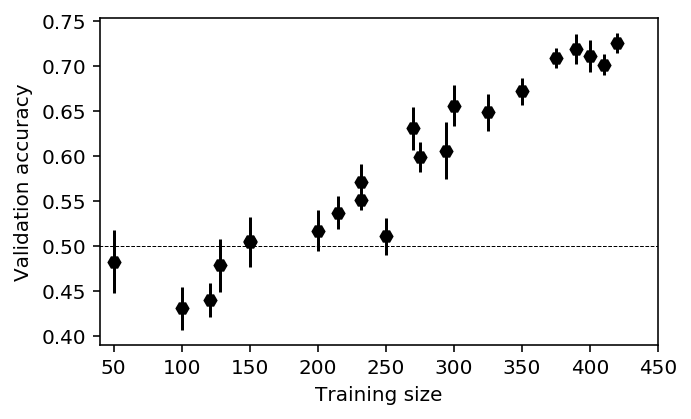

In [35]:
concat_path = '../model_data/grid_mix2_{}.pkl'.format('08')
df = pd.read_pickle(concat_path)

fig, ax = plt.subplots(1, figsize=(5, 3))

for fo, ts in zip(df.fit_outs, df.training_size):
    somma = [x.history['val_acc'] for x in fo]
    s = np.mean(somma, 0)[130:180].mean()
    err = np.mean(somma, 0)[130:180].std()
    ax.errorbar(ts, s, err, fmt='H', color='black')
    
ax.hlines(0.5, 0, 550, linestyles='--', linewidth= 0.5)
ax.set_xlim(40, 450)
ax.set(xlabel='Training size', ylabel='Validation accuracy');

# fig.savefig(f'../plots/training_size.png', bbox_inches='tight')